<a href="https://colab.research.google.com/github/spe301/AI-generated-AI/blob/main/AI_generated_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Potosnail==0.2.1

In [2]:
import pandas as pd
import numpy as np
from potosnail import *

ml = MachineLearning()
dl = DeepLearning()
dh = DataHelper()
ev = Evaluater()
al = Algorithms()
wr = Wrappers()
st = Stats()

def SuperBear(df):
  dh = DataHelper()
  '''gets the nlp results dataset ready for modeling'''
  df['regularizer'] = df['regularizer'].fillna('None')
  df['stacking'] = df['stacking'].astype(int)
  df['dropout'] = df['dropout'].astype(int)
  df['bidirectional'] = df['bidirectional'].astype(int)
  act = dh.OHE(df['activation'])
  reg = dh.OHE(df['regularizer'])
  opt = dh.OHE(df['optimizer'])
  method = dh.OHE(df['method'])
  df = df.drop(['activation', 'regularizer', 'optimizer', 'method'], axis='columns')
  df = pd.concat([df, act, reg, opt, method], axis='columns')
  df['val_loss'] = df['val_loss'].fillna(max(df['val_loss']))
  df['loss'] = df['loss'].fillna(max(df['loss']))
  return df

In [3]:
df1 = pd.read_csv('https://raw.githubusercontent.com/spe301/AI-generated-AI/main/Data/NLP8.csv').drop(['Unnamed: 0'], axis='columns')
nlp = SuperBear(df1)

# EDA Questions

1. is the difference in validation loss between 9,000 point datasets and 360 point datasets statistically signifigant?
2. is the difference in 'difference of validation loss and loss' between dropout and no dropout statistically signifigant?
3. Which model had the highest epochs and how many standard deviations away were it's accuracies from average (z score)
4. How is n_nodes correlated for smaller datasets compared to larger datasets?

In [4]:
from scipy.stats import ttest_ind

s1 = nlp.loc[nlp['len_dataset'] == 360]['val_loss'].sample(100)
s2 = nlp.loc[nlp['len_dataset'] != 360]['val_loss'].sample(100)
ttest_ind(s1, s2)

Ttest_indResult(statistic=8.7231388195817, pvalue=1.106088544388026e-15)

validation loss is signifigantly lower with larger dataset

conclusion: Deep NLP works better for larger datasets with thousands of datapoints.

In [5]:
ldd = nlp.loc[nlp['dropout'] == 1]['val_loss'] - nlp.loc[nlp['dropout'] == 1]['loss']
s1 = ldd.sample(100)
ldno = nlp.loc[nlp['dropout'] == 0]['val_loss'] - nlp.loc[nlp['dropout'] == 0]['loss']
s2 = ldno.sample(100)
ttest_ind(s1, s2)

Ttest_indResult(statistic=-0.09511000937926599, pvalue=0.9243236333863147)

We can accept the null hypothesis that dropout does not cause a signifigant change in loss

conclusion: adding a dropout layer is unlikley to decrease overfitting.

In [6]:
acc50 = np.mean(list(nlp.loc[nlp['epochs'] == max(nlp['epochs'])]['accuracy']))
val50 = np.mean(list(nlp.loc[nlp['epochs'] == max(nlp['epochs'])]['val_accuracy']))

st.Z(nlp['accuracy'], acc50), st.Z(nlp['val_accuracy'], val50)

(-1.8442059083699316, -0.43293229648074893)

In [7]:
val50

0.4987113395917047

Models that were trained for 50 epochs had lower accuracies than average but were also less overfit.

Conclusion: overfitting seems to be a major problem, setting epochs higher while figuring out how to increase accuracy may be well worth it.

In [8]:
np.mean(nlp['epochs'])

12.6425

In [9]:
kpi_list = ['accuracy', 'loss', 'val_accuracy', 'val_loss']
kpi = nlp[kpi_list]

scores = []
for i in range(len(nlp)):
  ts = (1 - (kpi['loss'][i] / max(kpi['loss'])) + kpi['accuracy'][i])/2
  vs = (1 - (kpi['val_loss'][i] / max(kpi['val_loss'])) + kpi['val_accuracy'][i])/2
  score = (ts+vs) - abs(ts-vs)
  scores.append(score)

nlp2 = nlp.drop(kpi_list, axis='columns')
nlp2['quality'] = scores
nlp2

,output_dim,embedding,nodes,stacking,dropout,bidirectional,epochs,batch_size,len_dataset,n_features,dominant_class,relu,tanh,L1,L2,None,adam,rmsprop,sgd,GRU,LSTM,quality
0,3,12300,64,0,0,0,7,32,8936,17,0.602954,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.338706
1,3,12300,64,1,0,0,7,32,8936,17,0.602954,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.361174
2,3,12300,64,0,0,0,7,32,8936,17,0.602954,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.361862
3,3,12300,64,1,0,0,6,32,8936,17,0.602954,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.387474
4,2,45589,64,0,0,0,6,32,360,1724,0.500000,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.490305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3,12300,256,0,1,1,6,32,8936,17,0.602954,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.405428
1996,3,12300,256,1,0,1,6,32,8936,17,0.602954,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.395079
1997,3,12300,256,1,0,1,7,32,8936,17,0.602954,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.341054
1998,3,12300,256,1,1,1,6,32,8936,17,0.602954,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.342763


In [48]:
counts = list(np.unique(nlp2['nodes']))

Text(0.5, 1.0, 'small datasets')

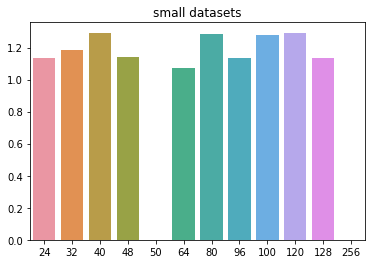

In [54]:
import seaborn as sns
from matplotlib import pyplot as plt

smaller = nlp2.loc[nlp2['len_dataset']==360]
bigger = nlp2.loc[nlp2['len_dataset']!=360]

quals1 = []
quals2 = []
for count in counts:
  avg_score1 = np.mean(smaller.loc[smaller['nodes'] == count]['quality'])
  avg_score2 = np.mean(bigger.loc[bigger['nodes'] == count]['quality'])
  quals1.append(avg_score1)
  quals2.append(avg_score2)

sns.barplot(counts, quals1)
plt.title('small datasets')

Text(0.5, 1.0, 'large datasets')

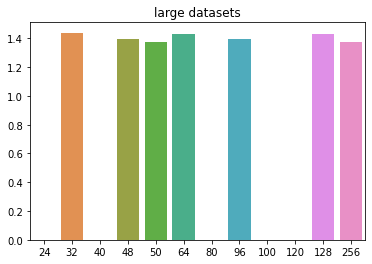

In [55]:
sns.barplot(counts, quals2)
plt.title('large datasets')

In [10]:
train, val = dh.HoldOut(nlp2)

In [14]:
kit = wr.WrapML(train, 'quality', 'regression', quiet=False)

75.49% accuracy, untuned model, raw data
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


86.37% accuracy, tuned model, raw data
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


69.95% accuracy, tuned model, data is scaled with standard scaler
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-8.45% accuracy, tuned model, features have been reduced to 5


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    1.6s finished


In [25]:
model = list(kit.values())[0][0]
X = list(kit.values())[0][1]
y = list(kit.values())[0][2]
Xval = list(kit.values())[0][3]
yval = list(kit.values())[0][4]
list(kit.values())[0][5]

In [26]:
model

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [30]:
grid = {'max_depth': [11, 12, 13], 'max_leaf_nodes': [9, 12, 15], 'min_samples_leaf': [3, 4]}

clf = ml.Optimize(model, grid, X, y)
clf

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    1.6s finished


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=12,
                      max_features=None, max_leaf_nodes=15,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [31]:
ev.EvaluateRegressor(clf, X, Xval, y, yval)

(     predicted    actual     error    %error
 0     1.184367  1.138172  0.046195  0.960996
 1     1.396522  1.411170  0.014648  1.037996
 2     1.135288  1.135954  0.000667  0.058691
 3     1.396522  1.368966  0.027556  0.980268
 4     1.135288  1.160250  0.024963  2.151501
 ..         ...       ...       ...       ...
 175   1.396522  1.357586  0.038936  0.972119
 176   1.396522  1.326643  0.069879  0.949962
 177   1.135288  1.247804  0.112517  9.017183
 178   1.396522  1.413435  0.016914  1.196636
 179   1.396522  1.401696  0.005174  0.369141
 
 [180 rows x 4 columns], 0.006998524759018363, 85.18)

In [32]:
X = np.array(X)
Xval = np.array(Xval)
y = np.array(y)
yval = np.array(yval)

In [43]:
dm = dl.FastNN('regression', 'mse', output_dim=1, nodes=32, regularizer='L2')
history = dm.fit(X, y, epochs=150, batch_size=32, validation_split=0.2)

Epoch 1/150
41/41 [==============================] - 1s 6ms/step - loss: 103674.3009 - val_loss: 2238.6355
Epoch 2/150
41/41 [==============================] - 0s 3ms/step - loss: 774.6535 - val_loss: 15.8291
Epoch 3/150
41/41 [==============================] - 0s 2ms/step - loss: 10.7478 - val_loss: 3.7940
Epoch 4/150
41/41 [==============================] - 0s 3ms/step - loss: 5.0770 - val_loss: 2.9615
Epoch 5/150
41/41 [==============================] - 0s 3ms/step - loss: 4.2240 - val_loss: 3.8137
Epoch 6/150
41/41 [==============================] - 0s 3ms/step - loss: 4.2380 - val_loss: 2.6623
Epoch 7/150
41/41 [==============================] - 0s 2ms/step - loss: 3.3170 - val_loss: 1.9239
Epoch 8/150
41/41 [==============================] - 0s 3ms/step - loss: 2.6901 - val_loss: 1.7310
Epoch 9/150
41/41 [==============================] - 0s 3ms/step - loss: 1.9739 - val_loss: 1.3874
Epoch 10/150
41/41 [==============================] - 0s 3ms/step - loss: 1.8335 - val_loss: 1.41

In [44]:
dm.evaluate(Xval, yval)

6/6 [==============================] - 0s 2ms/step - loss: 0.0813


0.08125180751085281

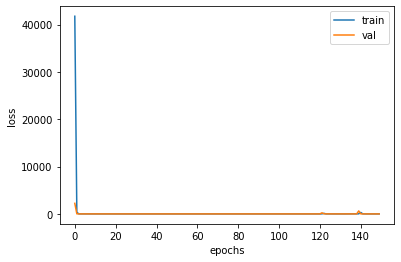

In [56]:
ev.ViewLoss(history)

In [73]:
[0.5] * 10

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

In [75]:
def BunnyPinkears(params, len_dataset, n_features, dominant_class):
  '''puts all possible gridsearch combinations in a dataframe'''
  n = list(params.keys())
  lst1 = []
  lst2 = []
  lst3 = []
  lst4 = []
  lst5 = []
  lst6 = []
  lst7 = []
  lst8 = []
  lst9 = []
  lst10 = []
  for i in range(len(params[n[0]])):
    var1 = params[n[0]][i]
    for i in range(len(params[n[1]])):
      var2 = params[n[1]][i]
      for i in range(len(params[n[2]])):
        var3 = params[n[2]][i]
        for i in range(len(params[n[3]])):
          var4 = params[n[3]][i]
          for i in range(len(params[n[4]])):
            var5 = params[n[4]][i]
            for i in range(len(params[n[5]])):
              var6 = params[n[5]][i]
              for i in range(len(params[n[6]])):
                var7 = params[n[6]][i]
                for i in range(len(params[n[7]])):
                  var8 = params[n[7]][i]
                  for i in range(len(params[n[8]])):
                    var9 = params[n[8]][i]
                    for i in range(len(params[n[9]])):
                      var10 = params[n[9]][i]
                      lst1.append(var1)
                      lst2.append(var2)
                      lst3.append(var3)
                      lst4.append(var4)
                      lst5.append(var5)
                      lst6.append(var6)
                      lst7.append(var7)
                      lst8.append(var8)
                      lst9.append(var9)
                      lst10.append(var10)
  df = pd.DataFrame(lst1)
  df.columns = [n[0]]
  df[n[1]] = lst2
  df[n[2]] = lst3
  df[n[3]] = lst4
  df[n[4]] = lst5
  df[n[5]] = lst6
  df[n[6]] = lst7
  df[n[7]] = lst8
  df[n[8]] = lst9
  df[n[9]] = lst10
  df['features'] = [n_features] * len(df)
  df['length'] = [len_dataset] * len(df)
  df['dominance'] = [dominant_class] * len(df)
  return df
                    
                    
grid = {'output_dim': [2], #because we have 2 classes
          'embedding': [45589], #vocab is number of unique words in dataset
          'nodes': list(range(32, 68, 4)), #we will test between 32 and 64 nodes for the first layer
          'activation': ['tanh', 'relu'], #we will test between relu and tanh for activation function
          'regularizer': ['L1', None, 'L2'], #we will use L1 reqularization to prevent overfitting
          'stacking': [False, True], #stacking makes the first 2 layers the same, we will not do this
          'dropout': [False, True], #we will not use dropout because we are already using L1 regularization
          'optimizer': ['adam', 'rmsprop', 'sgd'], #we will test between adam and rmsprop for optimization function
          'method': ['LSTM', 'GRU'], #we will test between using an LSTM cell and a GRU cell
          'bidirectional': [True, False]}

NlpGrid = BunnyPinkears(grid, 360, 17, 0.5)    
NlpGrid

,output_dim,embedding,nodes,activation,regularizer,stacking,dropout,optimizer,method,bidirectional,features,length,dominance
0,2,45589,32,tanh,L1,False,False,adam,LSTM,True,17,360,0.5
1,2,45589,32,tanh,L1,False,False,adam,LSTM,False,17,360,0.5
2,2,45589,32,tanh,L1,False,False,adam,GRU,True,17,360,0.5
3,2,45589,32,tanh,L1,False,False,adam,GRU,False,17,360,0.5
4,2,45589,32,tanh,L1,False,False,rmsprop,LSTM,True,17,360,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2587,2,45589,64,relu,L2,True,True,rmsprop,GRU,False,17,360,0.5
2588,2,45589,64,relu,L2,True,True,sgd,LSTM,True,17,360,0.5
2589,2,45589,64,relu,L2,True,True,sgd,LSTM,False,17,360,0.5
2590,2,45589,64,relu,L2,True,True,sgd,GRU,True,17,360,0.5
